<a href="https://colab.research.google.com/github/aleksandarb99/profession-and-gender-recognition/blob/develop/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import print_function

import os
from io import open
import requests
import shutil
import numpy as np
import json
from IPython.display import Image
from zipfile import ZipFile
from tensorflow import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Conv2D, Activation, Dropout, Flatten, Dense, MaxPooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras.preprocessing import image

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
execution_path = "/content/gdrive/MyDrive/profession-detection-master/"
DATASET_DIR = os.path.join(execution_path, "idenprof")
DATASET_TRAIN_DIR = os.path.join(DATASET_DIR, "train")
DATASET_TEST_DIR = os.path.join(DATASET_DIR, "test")

In [ ]:
save_direc = os.path.join(os.getcwd(), 'idenprof_models')

# Name of model files
model_name = 'idenprof_weight_model_VGG19.{epoch:03d}-{val_acc}.h5'

# Create Directory if it doesn't exist
if not os.path.isdir(save_direc):
    os.makedirs(save_direc)
# Join the directory with the model file
modelpath = os.path.join(save_direc, model_name)

# Checkpoint to save best model
checkpoint = ModelCheckpoint(filepath = modelpath, monitor = 'val_acc', verbose = 1, save_best_only = True,
                             save_weights_only = True, period=1)

In [ ]:
input_shape = (224, 224, 3)

model = Sequential(
    [Conv2D(64, (3, 3), input_shape=input_shape, padding='same',activation='relu'),
     Conv2D(64, (3, 3), activation='relu', padding='same'),
     MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
     Conv2D(128, (3, 3), activation='relu', padding='same'),
     Conv2D(128, (3, 3), activation='relu', padding='same',),
     MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
     Conv2D(256, (3, 3), activation='relu', padding='same',),
     Conv2D(256, (3, 3), activation='relu', padding='same',),
     Conv2D(256, (3, 3), activation='relu', padding='same',),
     Conv2D(256, (3, 3), activation='relu', padding='same',),
     MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
     Conv2D(512, (3, 3), activation='relu', padding='same',),
     Conv2D(512, (3, 3), activation='relu', padding='same',),
     Conv2D(512, (3, 3), activation='relu', padding='same',),
     Conv2D(512, (3, 3), activation='relu', padding='same',),
     MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
     Conv2D(512, (3, 3), activation='relu', padding='same',),
     Conv2D(512, (3, 3), activation='relu', padding='same',),
     Conv2D(512, (3, 3), activation='relu', padding='same',),
     Conv2D(512, (3, 3), activation='relu', padding='same',),
     MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
     Flatten(),
     Dense(10, activation="softmax")])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_17 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_19 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

In [ ]:
def train_network(model):
    optimizer = keras.optimizers.Adam(lr=0.01, decay=1e-4)
    batch_size = 32
    num_classes = 10
    epochs = 3
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    train_datagen = ImageDataGenerator(rescale=1. / 255,horizontal_flip=True)

    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(DATASET_TRAIN_DIR, target_size=(224, 224),batch_size=batch_size,
                                                        class_mode="categorical")
    test_generator = test_datagen.flow_from_directory(DATASET_TEST_DIR, target_size=(224, 224), batch_size=batch_size,
                                                      class_mode="categorical")
    model.fit_generator(train_generator, steps_per_epoch=int(9000 / batch_size), epochs=epochs,
                        validation_data=test_generator,validation_steps=int(2000 / batch_size),
                        callbacks=[checkpoint])

In [ ]:
train_network(model)

In [ ]:
CLASS_INDEX = None
MODEL_PATH = os.path.join(execution_path, "idenprof_VGG16_053-0.726.h5")
JSON_PATH = os.path.join(execution_path, "idenprof_model_class.json")

In [ ]:
model.load_weights(MODEL_PATH)

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.01, decay=1e-4)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(DATASET_TEST_DIR, target_size=(224, 224), batch_size = 32,
                                                  class_mode="categorical")
loss,accuracy = model.evaluate_generator(test_generator,steps=int(2000 / 32))
print("Accuracy =", accuracy)

In [ ]:
def preprocess_input(x):
    x *= (1. / 255)
    return x

In [ ]:
def decode_predictions(preds, top=5, model_json=""):
    global CLASS_INDEX
    if CLASS_INDEX is None:
        CLASS_INDEX = json.load(open(model_json))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        for i in top_indices:
            each_result = []
            each_result.append(CLASS_INDEX[str(i)])
            each_result.append(pred[i])
            results.append(each_result)
    return results

In [ ]:
def run_inference(model,picture):
    image_to_predict = image.load_img(picture, target_size=(224, 224))
    image_to_predict = image.img_to_array(image_to_predict, data_format="channels_last")
    image_to_predict = np.expand_dims(image_to_predict, axis=0)

    image_to_predict = preprocess_input(image_to_predict)

    prediction = model.predict(x=image_to_predict, steps=1)

    predictiondata = decode_predictions(prediction, top=int(5), model_json=JSON_PATH)

    for result in predictiondata:
        print(str(result[0]), " : ", str(result[1] * 100))

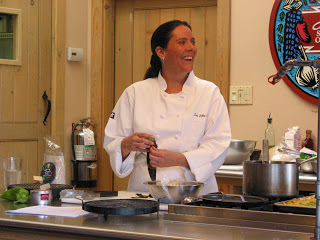

chef  :  95.45511603355408
waiter  :  2.166222594678402
mechanic  :  1.8960759043693542
engineer  :  0.3939555957913399
firefighter  :  0.05119987181387842


In [ ]:
picture = os.path.join(execution_path, "test-images/1.jpg")
display(Image(filename=picture))
run_inference(model,picture)

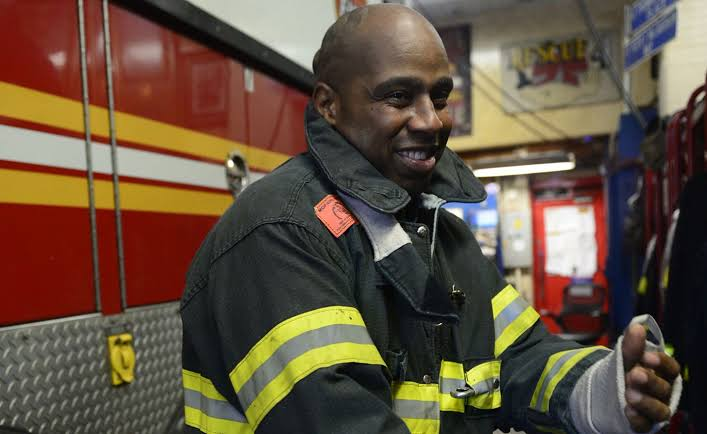

firefighter  :  56.94112181663513
engineer  :  24.50576424598694
judge  :  6.125786900520325
mechanic  :  5.769829452037811
waiter  :  2.3413514718413353


In [ ]:
picture = os.path.join(execution_path, "test-images/2.jpg")
display(Image(filename=picture))
run_inference(model,picture)

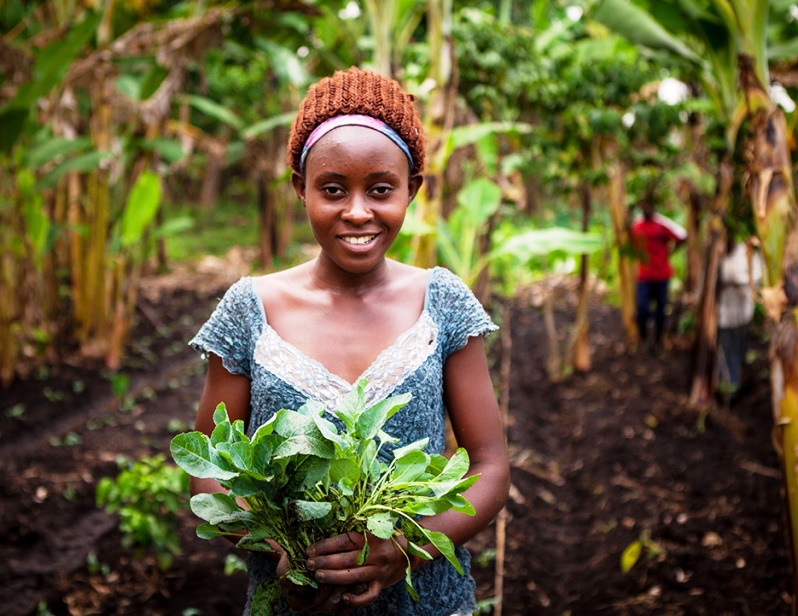

farmer  :  99.95148181915283
police  :  0.044091150630265474
firefighter  :  0.0036186254874337465
mechanic  :  0.0007599726814078167
engineer  :  2.44058128373581e-05


In [ ]:
picture = os.path.join(execution_path, "test-images/3.jpg")
display(Image(filename=picture))
run_inference(model,picture)

In [4]:
import os
import numpy as np
import cv2 # OpenCV
from sklearn.svm import SVC # SVM klasifikator
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier # KNN
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [5]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)

def display_image(image):
    plt.imshow(image, 'gray')

In [6]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

<function camera at 0x7fe32cc4a200>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  # Remove the CWD from sys.path while we load stuff.


10


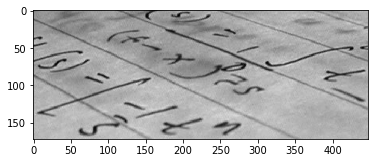

In [7]:
from skimage import data, transform
from skimage import data, color, feature

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']

print(getattr(data, imgs_to_use[0]))
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]
display_image(images[1])
print(len(images))

In [8]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

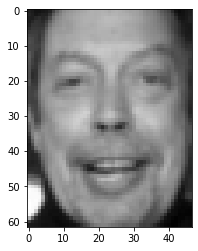

In [9]:
display_image(positive_patches[0])

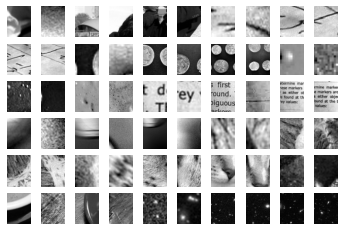

In [10]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

In [314]:
from itertools import chain
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [315]:
X_train.shape

(43233, 1215)

In [16]:
def f(size):
  # print(size)
  # train_dir_pos = execution_path + 'gender-detection/Training-data'
  # train_dir_neg = execution_path + 'gender-detection/Negative'
  # img = None

  # pos_imgs = []
  # neg_imgs = []

  # for img_name in os.listdir(train_dir_pos):
  #     img_path = os.path.join(train_dir_pos, img_name)
  #     img = load_image(img_path)
  #     img = cv2.resize(img, size)
  #     pos_imgs.append(img)
          
  # for img_name in os.listdir(train_dir_neg):
  #     img_path = os.path.join(train_dir_neg, img_name)
  #     img = load_image(img_path)
  #     img = cv2.resize(img, size)
  #     neg_imgs.append(img)

    # return img, pos_imgs, neg_imgs

  # def make_features(pos_imgs, neg_imgs, img):
  pos_features = []
  neg_features = []
  labels = []
  x = None
  y = None
  img = positive_patches[0]
  img = cv2.resize(img, size)
  img = img.astype(np.uint8)

  nbins = 9 # broj binova
  cell_size = (8, 8) # broj piksela po celiji
  block_size = (3, 3) # broj celija po bloku

  hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1], 
                                    img.shape[0] // cell_size[0] * cell_size[0]),
                          _blockSize=(block_size[1] * cell_size[1],
                                      block_size[0] * cell_size[0]),
                          _blockStride=(cell_size[1], cell_size[0]),
                          _cellSize=(cell_size[1], cell_size[0]),
                          _nbins=nbins)

  for img in positive_patches:
      img = cv2.resize(img, size)
      img = img.astype(np.uint8)
      pos_features.append(hog.compute(img))
      labels.append(1)

  for img in negative_patches:
      img = cv2.resize(img, size)
      img = img.astype(np.uint8)
      neg_features.append(hog.compute(img))
      labels.append(0)

  pos_features = np.array(pos_features)
  neg_features = np.array(neg_features)
  x = np.vstack((pos_features, neg_features))
  y = np.array(labels)

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

  x_train = reshape_data(x_train)
  x_test = reshape_data(x_test)

  clf_svm = SVC(kernel='linear', probability=True) 
  clf_svm.fit(x_train, y_train)
  y_train_pred = clf_svm.predict(x_train)
  y_test_pred = clf_svm.predict(x_test)
    # print("Train accuracy: ", accuracy_score(y_train, y_train_pred))
    # print("Validation accuracy: ", accuracy_score(y_test, y_test_pred))
  return clf_svm, hog
  

# transformisemo u oblik pogodan za scikit-learn
def reshape_data(input_data):
    nsamples, nx, ny = input_data.shape
    return input_data.reshape((nsamples, nx*ny))


# x, y, w, h = cv2.boundingRect(contour)
# region = image_bin[y:y+h+1, x:x+w+1]
# regions_array.append([resize_region(region), (x, y, w, h)])
# cv2.rectangle(image_orig, (x, y), (x+w, y+h), (0, 255, 0), 2)

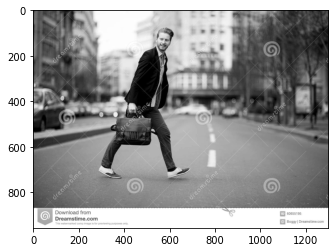

In [12]:
itest = load_image(execution_path + 'test-images/test (9).jpg')
display_image(itest)

In [13]:
def classify_window(window, clf, hog):
    features = hog.compute(window).reshape(1, -1)
    return clf.predict_proba(features)[0][1]

In [14]:
def process_image(image, clf, hog, step_size, window_size=(85,105)):
    best_score = 0
    best_window = None
    for y in range(0, image.shape[0], step_size):
        for x in range(0, image.shape[1], step_size):
            this_window = (y, x) # zbog formata rezultata
            window = image[y:y+window_size[1], x:x+window_size[0]]
            if window.shape == (window_size[1], window_size[0]):
                score = classify_window(window, clf, hog)
                if score > best_score:
                    best_score = score
                    best_window = this_window
                    w = window
    return best_score, best_window, w

In [17]:
size=(40,50)
clf_hog = []
# for x in range(10):
clf, hog = f(size)
clf_hog.append((clf, hog, size))
  # size = scale(size)

In [18]:
scores = []
for x in clf_hog:
  score, score_window, w = process_image(itest, x[0], x[1], step_size=10, window_size=x[2])
  scores.append((score, score_window, w))

In [20]:
print(scores[0][0])

0.9999960179888703


In [ ]:
def scale(size):
  first = size[0]
  addedTen = first + 10
  x = math.floor(size[1] * addedTen / first)
  return (addedTen, x)

In [ ]:
scale((100,123))

(110, 135)

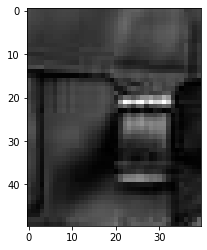

In [21]:
display_image(scores[0][2])
# display_image(scores[1][2])
# display_image(scores[2][2])

In [ ]:
print(score)
print(score_window)

cao
0.996339252993863
(90, 120)
